In [72]:
import os
import nltk
import math
import random
import string
import pandas as pd
import seaborn as sns
from collections import deque
import matplotlib.pyplot as plt
from collections import Counter

from nltk.util import ngrams
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import edit_distance
from nltk.corpus import stopwords

## 1. Implementation of bigram and trigram language models
---

We are going to use the European Parliament Proceedings dataset, as offered by the `nltk` package:

In [3]:
# read europarl files into a list of lists (10 files = 10 lists)
corpus = []
data_dir = './europarl_raw/english/'
for file_id in os.listdir(data_dir):
    with open(data_dir + file_id, 'r', encoding='utf-8') as curr_file:
        corpus.append(curr_file.readlines())

The whole dataset consists of 10 different files. Hence, we will flatten and transform the corpus to a single string. Then, we tokenize it to sentence level:

In [4]:
# flatten corpus list into a single string
corpus = [word for file in corpus for word in file] 
corpus_raw = ''.join(corpus)

# tokenize corpus to sentences
sentences_tokenized = []
for sentence in sent_tokenize(corpus_raw):
    sentences_tokenized.append(sentence)

We divide our dataset to 80% training and 20% test. We do so at the sentence level:

In [5]:
# shuffle
random.shuffle(sentences_tokenized)
split_80 = len(sentences_tokenized) * 80 // 100

# split to train and test
test_sentences = sentences_tokenized[split_80:]
train_sentences = sentences_tokenized[:split_80]

Before tokenizing our training corpus to word level, we will remove stopwords:

In [6]:
# define stopword accumulator
stopwords_acc = [stopwords.words('english')]
stopwords_acc.extend(string.punctuation)
stopwords_acc.extend(["the", "of", "and"])

Using just the training corpus, we also define our dataset's vocabulary:

In [50]:
# vocabulary generation

acc = []
for sentence in train_sentences:
    acc += [word for word in word_tokenize(sentence)]
    
vocabulary = []
for key, value in dict(Counter(acc)).items():
    if value > 25 and key not in stopwords_acc and not key.isnumeric():
        vocabulary.append(key)

Last but not least, we tokenize training and test sets to word level. For the test set, we will replace OOV terms with the `UKN` token:

In [8]:
# tokenize sentences to word level, remove stopwords

train_sentences_tokenized = []
for sentence in train_sentences:
    curr = word_tokenize(sentence)
    curr = [word for word in curr if word not in stopwords_acc]
    train_sentences_tokenized.append(curr)
    
test_sentences_tokenized = []
for sentence in test_sentences:
    curr = word_tokenize(sentence)
    curr = [word for word in curr if word not in stopwords_acc]
    curr_voc = []
    for word in curr:
        if word not in vocabulary:
            word = 'UNK'
        curr_voc.append(word)
    test_sentences_tokenized.append(curr_voc)

For general perspective reasons, we provide the number of sentences, tokens and unique tokens in the training and test sets:

In [9]:
# summary statistics

print('Train | {} sentences, {} tokens, {} unique tokens'.
      format(
          len(train_sentences),
          len([word for sentence in train_sentences_tokenized for word in sentence]),
          len(set([word for sentence in train_sentences_tokenized for word in sentence]))
      )
)
print('Test  | 0{} sentences, 0{} tokens, 0{} unique tokens'.
      format(
          len(test_sentences),
          len([word for sentence in test_sentences_tokenized for word in sentence]),
          len(set([word for sentence in test_sentences_tokenized for word in sentence]))
      )
)

Train | 15928 sentences, 347228 tokens, 15174 unique tokens
Test  | 03982 sentences, 086502 tokens, 01696 unique tokens


For the training of the models, we will left-pad our n-grams with the the token `s` and right-pad them with the `e` token.

In [10]:
unigram_counter, bigram_counter, trigram_counter = Counter(), Counter(), Counter()

for sent in train_sentences_tokenized:
    unigram_counter.update(
        [gram for gram in ngrams(
            sent,
            1, 
            pad_left=True, 
            pad_right=True)
        ]
    )
    bigram_counter.update(
        [gram for gram in ngrams(
            sent,
            2, 
            pad_left=True, 
            pad_right=True, 
            left_pad_symbol='<s>',
            right_pad_symbol='<e>')
        ]
    )
    trigram_counter.update(
        [gram for gram in ngrams(
            sent, 
            3, 
            pad_left=True, 
            pad_right=True,
            left_pad_symbol='<s>',
            right_pad_symbol='<e>')
        ]
    )

For exploratory reasons, we visualize the top 10 occurencies of each model:

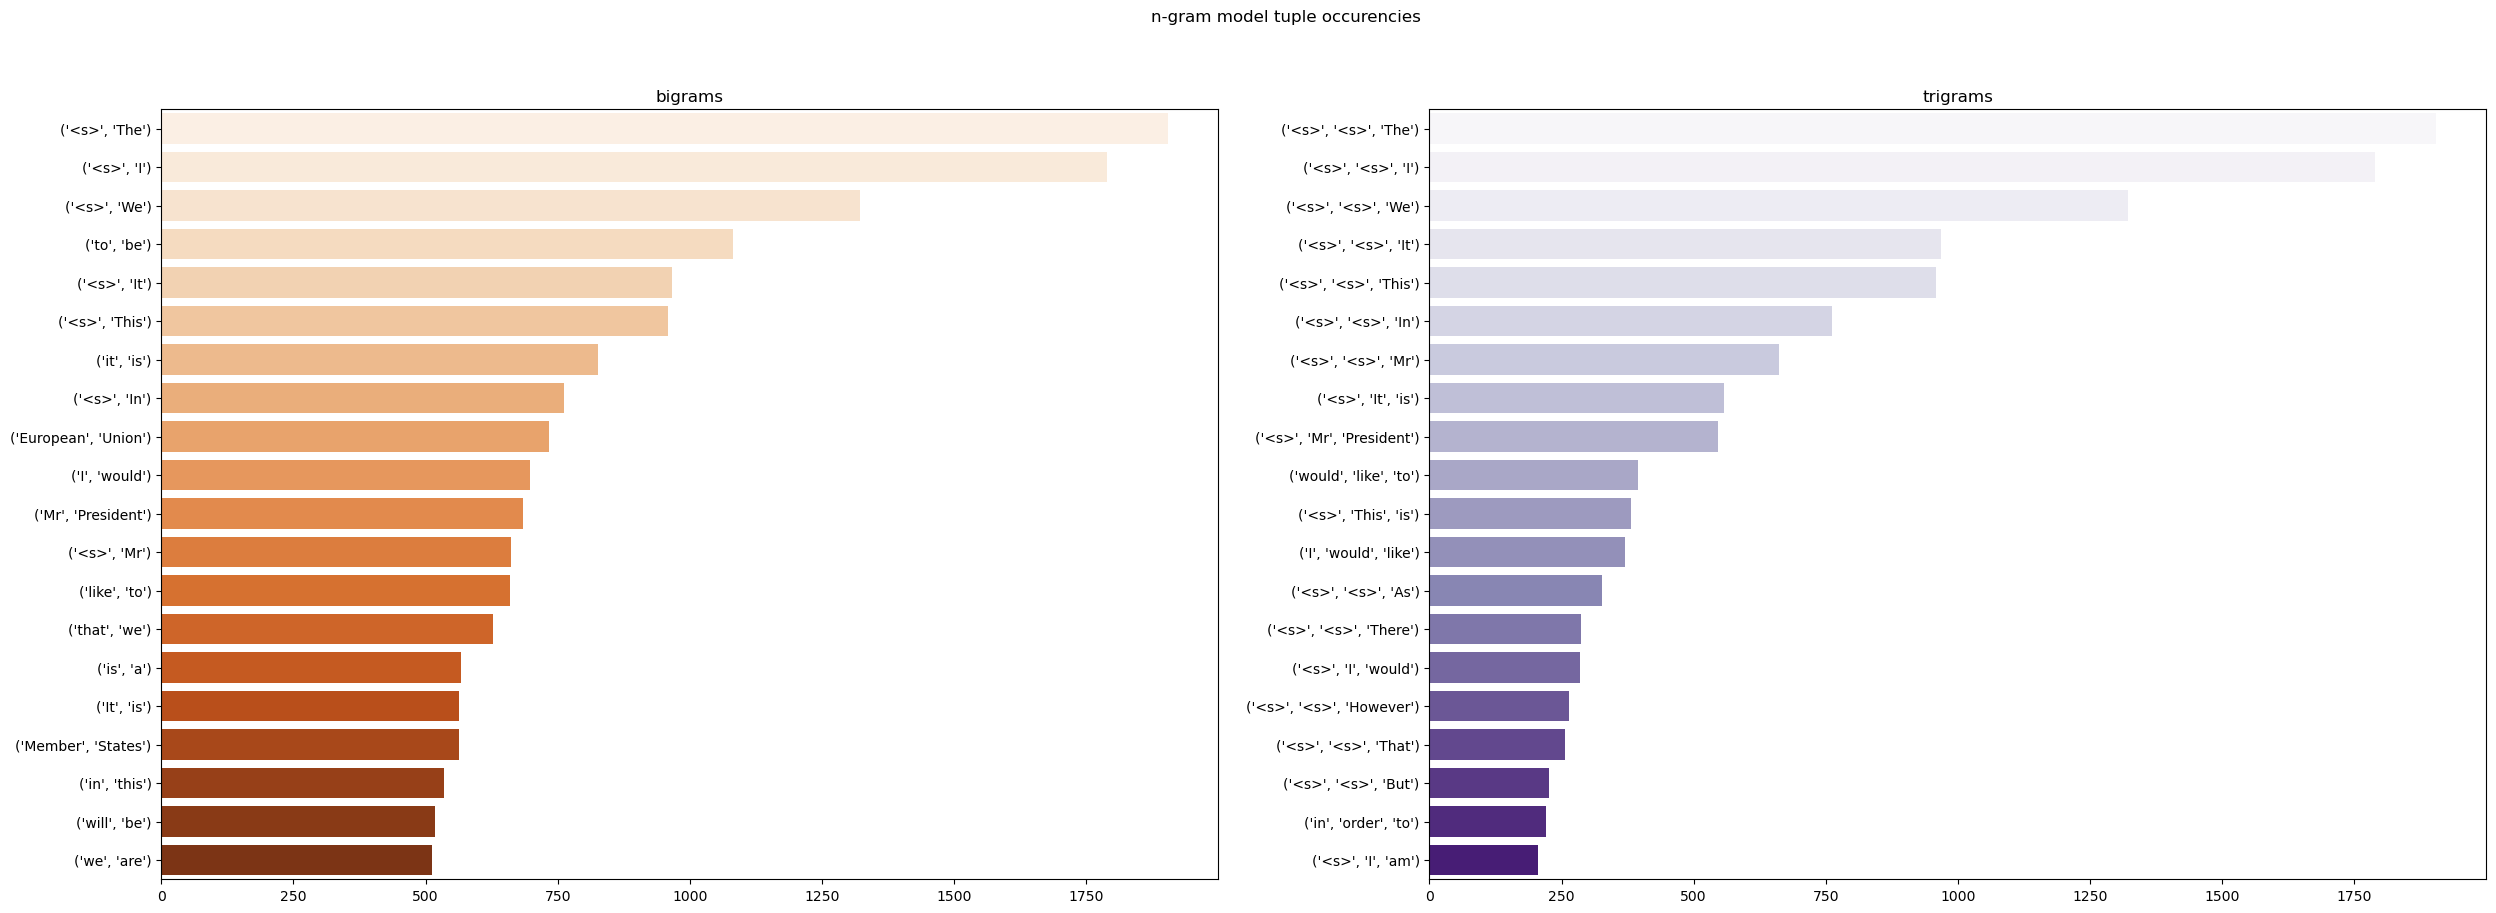

In [11]:
dfb = pd.DataFrame(bigram_counter.most_common(20), columns =['bigram', 'count'])
dft = pd.DataFrame(trigram_counter.most_common(20), columns =['trigram', 'count'])

sns.set_palette(sns.color_palette('BuPu'))
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
fig.suptitle('n-gram model tuple occurencies')
sns.barplot(ax=axes[0], data=dfb, x="count", y="bigram", palette="Oranges").set_title('bigrams')
sns.barplot(ax=axes[1], data=dft, x="count", y="trigram", palette='Purples').set_title('trigrams')
axes[0].set(xlabel='', ylabel='')
axes[1].set(xlabel='', ylabel='')
plt.show()

## 2. Calculating cross-entropy and perplexity
---

We will calculate the cross entropy and perplexity of the two models by implementing Laplace smoothing with `α=0.1`.

In [12]:
alpha = 0.1
vocabulary_size = len(vocabulary)

In [52]:
bigram_count = 0
probability_sum = 0

for sentence in test_sentences_tokenized:
    
    sentence = sentence + ['<e>'] # ignore <start> tokens

    for word in range(1, len(sentence)):
        bigram_probability = (bigram_counter[(sentence[word-1], sentence[word])] + alpha) / (unigram_counter[(sentence[word-1], )] + alpha*vocabulary_size)
        probability_sum += math.log2(bigram_probability)
        bigram_count += 1

cross_entropy = - probability_sum / bigram_count
perplexity = math.pow(2, cross_entropy)

print("Bigram cross entropy: {0:.2f}".format(cross_entropy))
print("Bigram perplexity: {0:.2f}".format(perplexity))

Bigram cross entropy: 8.50
Bigram perplexity: 361.14


In [53]:
trigram_count = 0
probability_sum = 0

for sentence in test_sentences_tokenized:
    
    sentence = sent + ['<e>'] + ['<e>'] # ignore <start> tokens

    for word in range(2, len(sent)-1):
        trigram_probability = (trigram_counter[(sentence[word-2], sentence[word-1], sentence[word])] + alpha) / (bigram_counter[(sentence[word-2], sentence[word-1])] + alpha*vocabulary_size)
        probability_sum += math.log2(trigram_probability)
        trigram_count += 1

cross_entropy = - probability_sum / trigram_count
perplexity = math.pow(2, cross_entropy)

print("Trigram cross entropy: {0:.2f}".format(cross_entropy))
print("Trigram perplexity: {0:.2f}".format(perplexity))

Trigram cross entropy: 6.96
Trigram perplexity: 124.21


We notice how the trigram models achieves smaller cross entropy and perplexity values, indicating better performance.

## 3. Context-aware spelling corrector
---

In [132]:
def spelling_corrector(sentence_tokenized, vocabulary):
    
    sentence = ['<s>'] + sentence_tokenized + ['<e>']

    queue = deque()
    queue.append([sentence[0]])

    while queue:

        # get latest form of potential sentence and append the next-in-line word
        curr = queue.popleft() 
        sentence_index = len(curr)
        
        # if end-of-sentence is reached, terminate
        if sentence_index < len(sentence):
            curr.append(sentence[sentence_index])
        else:
            break

        # calculate Levenshtein distances with every vocabulary token, work on the top 10 predictions
        levenshtein_acc = [(0, curr[-1])]
        for token in vocabulary:
            levenshtein_acc.append((edit_distance(token, curr[-1]), token))

        # calculate model probabilities among the predictions of the previous steps
        probability_acc = []
        for canditate in sorted(levenshtein_acc)[:10]:
            probability = (bigram_counter[(curr[0], canditate[1])] + alpha) / (unigram_counter[(curr[-2], )] + alpha*vocabulary_size)
            probability_acc.append((probability, canditate[0], canditate[1]))

        # keep 2 potential paths for the current state of the sentence (maximum probability, minimum Levenshtein)
        for path in sorted(probability_acc, key=lambda x: (-x[0], x[1]))[:2]:
            current_string = curr.copy()
            current_string[-1] = path[2]
            queue.append(current_string)